# Class Differentiation Measure Graphical Idea
The idea of this notebook is providing a graphical intuition of the Class Differentiation Measure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import tensorflow as tf
#from tensorflow import keras
import gc
from pathlib import Path
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Magics first (server issues)

# if you want static matplotlib plot :
#%matplotlib inline 
# Do below if you want interactive matplotlib plot :
%matplotlib notebook 

# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
#Customisations


#Any tweaks that normally go in .matplotlibrc, etc. should explicity go here
plt.rcParams['figure.figsize'] = (7,5)
%config InlineBackend.figure_format='retina'

In [2]:
def distance_to_point(point,array):
    dist = []
    for i in range(array.shape[0]):
        d = np.linalg.norm(point-array[i])
        dist.append(d)
    return np.array(dist)

def distance_factor(sample,mode = 0):
    """
    This function computes the relative contrast provided by the paper  "ON the suprising behaviour". 
    In this case, the relative constras will be computed with respect the mean.
    
    Parameters:
    ----------
    sample: Dataset from which the relative factor must be computed.
    mode: working mode. Default:0
    
    Return
    ------
    rt : Relative contrast.
    """
    if mode == 0:
        dt = centroid_distance(sample)
        m = np.min(dt)
        M = np.max(dt)
        rt = (M-m)/m
        return rt
    

def mahalanobis(array,observations):
    """
    This function computes the Mahalanobis "Norm" of a provided vector array and a provided set of
     observations
    
    Parameters
    ----------
    array: Provided array. This distance will provide a measure of how much this vector belongs to
    the provided set of vectors.
    observations: Set of previous observations.
    
    Return
    ------
    Mahalanobis distance to the provided set.
    
    """
    observations = np.transpose(observations)
    #print(f'Observations shape: {observations.shape}')
    mean = np.mean(observations,axis = 1)
    #print(f'Mean  {mean}')
    cov = np.cov(observations)
    inv_cov = np.linalg.inv(cov)
    #print(f'Cov: {cov}')
    v = array - mean
    distance = np.sqrt(np.matmul(np.matmul(v,inv_cov),v))
    return distance

def d_mahalanobis_distance(sample):
    """
    This function computes the mahalanobis distance of each single point to itself
    
    Parameters
    ----------
    sample. samples or dataset used to compute the mahalanobis distance.
    
    Return
    ------
    d_v: distance vector
    """
    d_v = []
    for i in sample:
        d_v.append(mahalanobis(i,sample))
    d_v = np.array(d_v)
    return d_v

def centroid_distance(sample):
    """
    This function computes the distance from the mass center of a given set to each other point
    
    Parameter
    ---------
    sample: sample of elements on which the method will be applied.
    
    Return
    ------
    d_v: distance vector
    """
    m = np.mean(sample,axis=0)
    d_v=distance_to_point(m,sample)
    return d_v

def density_funct_estimation(sample,density_factor=100):
    """
    This function computes the density estimation associated to a category in a
    dataset.
    """
    q = []
    for i in range(1,density_factor):
        q.append(np.quantile(sample,i/density_factor))
    q = np.array(q)
    q = np.concatenate((np.array([np.min(sample)]),q,np.array([np.max(sample)])))
    dq = np.diff(q)
    h = (1/density_factor)/dq

    return q[1:],h

def quantile_entropy(density_vector):
    """
    This function computes the entropy associated to a simple density function made out of constant values
    obtained for equally spaciated quantiles.
    
    Parameters
    ----------
    density_vector: array. Vector containing the densities obtained for a specific sample.
    
    Return
    ------
    qe: Scalar value associated to the entropy of the sample.
    
    """
    c = 1/density_vector.shape[0]
    qe = (-c)*np.sum(np.log(density_vector))
    return qe
def n_sphere_vol(r,dim = 2):
    if dim%2 == 0:
        k = dim/2
        volume = ((np.pi**k)/np.math.factorial(k))*r**dim
    elif dim%2 == 1:
        k = dim//2
        volume = ((2*np.math.factorial(k)*(4*np.pi)**k)/(np.math.factorial(dim)))*r**dim     
    return volume

def mutual_density(target_random_sample, non_target_random_sample,non_target_quantiles ):
    """
    This function computes the empirical probability measure of the intersection of two 
    categories within a dataset.
    
    Params
    --------
    target_random_sample: np.array. Samples that belongs to the target category. The
                          probability measure will be computed with respect the empirical
                          probability distribution associated to this category.
    non_target_random_sample: np.array. Samples that belong to some other category. If 
                          these two categories are not disjoint then the intersection will
                          be a measurable set and its measure can be computed with respect
                          the different probability measures.
    non_target_quantiles: np.array. Array that contains the quantiles of distances with respect
                          the non_target_random_sample.
                          
    Return
    -------
    m: float. Measure of the intersection of the two categories with respect the empirical prob
              bability measure defined for the target_random_sample-
    """
    
    r = non_target_quantiles[-1]
    c2 = np.mean(non_target_random_sample,axis=0)
    distances_to_c2 = distance_to_point(point = c2,array = target_random_sample)
    categories_intersection = distances_to_c2[np.where(distances_to_c2<=r)]
    m = categories_intersection.shape[0]/target_random_sample.shape[0]
    return m

def intersection_divergence_entropy(dataset_1,dataset_2):
    """
    Test
    """
    distances1 = centroid_distance(dataset_1)
    distances2 = centroid_distance(dataset_2)
    q1,h1 = density_funct_estimation(distances1)
    q2,h2 = density_funct_estimation(distances2)
    m1 = mutual_density(dataset_1,dataset_2,q2)
    m2 = mutual_density(dataset_2,dataset_1,q1)
    i_d_e = m1*np.log(m1/m2)
    return i_d_e

def mutual_density_divergence(target_category, category_list):
    """
    This function computes a coefficient associated to the measure of
    the intersections of a measurable set with respect someother measurable sets 
    for a set of probability measures. This coefficient intends to provide insights 
    of the average 'size'of these intersections and, in that way, how distinguishable
    is a set from others.
    
    Parameters
    -----------
    target_category: array. Dataset associated to the target category for which the coe-
                     fficient will be computed.
    category_list: list of arrays. This list must contain all datasets associated to the 
              different categories  in a classification problem.
    mode: int. Used mean method. Default:0 Arithmetic mean. 1, geometric mean.
    
    Return
    -------
    phi: float. Coefficient associated to the target category.
    
    """

    relative_measures = []
    for category in category_list:
        d = centroid_distance(category)
        q,h = density_funct_estimation(d)
        m=mutual_density(target_category,category,q)
        relative_measures.append(m)
    relative_measures = np.array(relative_measures)
    phi = np.mean(np.log(1/(1-relative_measures)))
    return phi, relative_measures

def dataset_density_function_estimation(dataset):
    d = centroid_distance(dataset)
    q,h = density_funct_estimation(d)
    return q,h

def dataset_quantile_entropy(dataset):
    q,h = dataset_density_function_estimation(dataset)
    e = quantile_entropy(h)
    return e
def mean_categorical_entropy(category_list):
    """
    This function computes the mean categorical entropy defined for n categories in
    a classification problem as (phi1*h1+...+phin*hn)/n
    
    Parameters
    -----------
    
    category_list:list of arrays. This list must contain all datasets associated to the 
              different categories  in a classification problem.
    
    Return
    --------
    mce:float. Mean Cathegorical Entropy. 
    """
    entropies = []
    mdd_coefficients=[]
    
    for i in  range(category_list.shape[0]):
        quantile_entropy = dataset_quantile_entropy(category_list[i])
        entropies.append(quantile_entropy)
        target_category = category_list[i]
        non_target_category = np.delete(category_list,i,axis = 0)
        #print(f'shape {non_target_category.shape}')
        phi,_relative_measures = mutual_density_divergence(target_category = target_category,category_list = non_target_category)
        print(f'Relative Measures {_relative_measures}')
        print(f'Coefficients {phi}')
        mdd_coefficients.append(phi)
    entropies = np.array(entropies)
    mdd_coefficients = np.array(mdd_coefficients)    
    mce = np.mean(100*np.log2(mdd_coefficients)+entropies)
    return mce



def category_finder(training_dataset,category_column):
    """
    This function takes a pandas DataFrame training_dataset as 
    input and returns a set of pandas DataFrame each associated 
    to a specific category
    
    Parameters
    ----------
    training_dataset: Pandas DataFrame. DataFrame that contains the
                      training dataset
    category_columns: str. Name of the column that contains the 
    categories
    
    Returns: category_dict. Dictionary that contains the different
            categories dataframes
    """
    category_dict = {}
    categories = training_dataset[category_column].unique()
    #print(f'Unique Values: {categories}')
    for i in range(categories.shape[0]):
        #print(f'Categoria: {categories[i]}')
        name = categories[i]
        current_df = training_dataset.loc[training_dataset[category_column]==categories[i]].copy()
        category_dict[name]= current_df
    return category_dict

def mean_mutual_density_divergence(dataset,representation_columns,category_column):
    """
    this function computes the mean mutual density divergence.
    
    Parameters
    ----------
    dataset: pandas DataFrame. dataset that is going to be used for training the model (
             all columns must be included)
    representation_columns: list of str. Names of the columns that stand for the representation,
                          i.e. the feature columns
    category_column: str. Name of the column that contains the categories
    
    Return
    ------
    mean_phi: float. Mean of the phi values associated to the different mutual density divergence
    
    phis: list of float. List of phi values associated to the different mutual density divergence
    
    """
    
    categories = category_finder(dataset,category_column)
    categories_names = list(categories.keys())
    phis = []
    for i in range(len(categories_names)):
        remaining_category_names = categories_names.copy()
        target_category_name = categories_names[i]
        remaining_category_names.remove(target_category_name)
        #print(f'Target Category Name: {target_category_name}')
        #print(f'Remaining Category Name: {remaining_category_names}')
        #computing the divergence
        target_X = categories[target_category_name][representation_columns].values
        #print(f'This is target_X: { target_X}')
        complementary_targets = [categories[name][representation_columns].values for name in remaining_category_names]
        #print(f'These are complementary targets: {complementary_targets}')
        
        phi,rm = mutual_density_divergence(target_category=target_X, category_list=complementary_targets)
        phis.append(phi)
        #print(f'Mean phi:{np.mean(phis)}\nList of phis: {phis}')
        
        del remaining_category_names
    return np.mean(phis),phis

def average_inner_distance(target_points, data):
    """
    This function compute the average distance from a representation
    of a set called data to a series of target points.
    
    Parameters
    ----------
    target_points: np.array. Array of target points. These points are 
                   the reference points for computing the average distance.
    data: np.array. Array associated to the data points for a especific 
                    representation.
                    
    Return
    ------
    mean_dist: float. Mean distance to the different points
    std_dist:  float. Standard deviation of the distances.
    """
    distances_array = np.zeros(shape=(target_points.shape[0],data.shape[0],target_points.shape[1]))
    for i in range(target_points.shape[0]):
        distances_array[i]= target_points[i] - data
    d = np.linalg.norm(distances_array,axis = 2)
    m_d = np.min(d,axis = 1)
    mean_dist = np.mean(m_d)
    std_dist = np.std(m_d)
    return mean_dist, std_dist
    
    
def dataset_intersection_counter(target_reference_points, radius, target_dataset):
    """
    This function counts the number of points of a target dataset inside the covering
    defined by the balls of centers in target_reference_points (coming from a reference dataset)
    with radius radius.
    The idea is to detect if two given datasets the intersectionis void or not.
    
    Parameters
    ----------
    target_reference_points: np.array. Array of target points. These points come from the targe dataset of
                   reference.
    radius: float. Radius of the balls
    target_dataset: np.array. Array of points associated to someother dataset whose intersection 
    with the reference dataset wants to be computed.
    
    Returns
    -------
    intersection_measure: float. This value is the number of target reference points that have points 
                          of target dataset inside a ball of center a target_point and radius radius.
    """
    distances_array = np.zeros(shape=(target_reference_points.shape[0],target_dataset.shape[0],target_reference_points.shape[1]))
    for i in range(target_reference_points.shape[0]):
        distances_array[i]= target_reference_points[i] - target_dataset
    d = np.linalg.norm(distances_array,axis = 2)
    n_intersection_indexes = np.unique(np.where(d <= radius)[0]).shape[0]
    intersection_measure = n_intersection_indexes/target_reference_points.shape[0]
    return intersection_measure

def average_inner_distance(target_points, data):
    """
    This function compute the average distance from a representation
    of a set called data to a series of target points.
    
    Parameters
    ----------
    target_points: np.array. Array of target points. These points are 
                   the reference points for computing the average distance.
    data: np.array. Array associated to the data points for a especific 
                    representation.
                    
    Return
    ------
    mean_dist: float. Mean distance to the different points
    std_dist:  float. Standard deviation of the distances.
    """
    distances_array = np.zeros(shape=(target_points.shape[0],data.shape[0],target_points.shape[1]))
    for i in range(target_points.shape[0]):
        distances_array[i]= target_points[i] - data
    d = np.linalg.norm(distances_array,axis = 2)
    m_d = np.min(d,axis = 1)
    mean_dist = np.mean(m_d)
    std_dist = np.std(m_d)
    return mean_dist, std_dist
    
    
def dataset_intersection_counter(target_reference_points, radius, target_dataset):
    """
    This function counts the number of points of a target dataset inside the covering
    defined by the balls of centers in target_reference_points (coming from a reference dataset)
    with radius radius.
    The idea is to detect if two given datasets the intersectionis void or not.
    
    Parameters
    ----------
    target_reference_points: np.array. Array of target points. These points come from the targe dataset of
                   reference.
    radius: float. Radius of the balls
    target_dataset: np.array. Array of points associated to someother dataset whose intersection 
    with the reference dataset wants to be computed.
    
    Returns
    -------
    intersection_measure: float. This value is the number of target reference points that have points 
                          of target dataset inside a ball of center a target_point and radius radius.
    """
    distances_array = np.zeros(shape=(target_reference_points.shape[0],target_dataset.shape[0],target_reference_points.shape[1]))
    for i in range(target_reference_points.shape[0]):
        distances_array[i]= target_reference_points[i] - target_dataset
    d = np.linalg.norm(distances_array,axis = 2)
    n_intersection_indexes = np.unique(np.where(d <= radius)[0]).shape[0]
    intersection_measure = n_intersection_indexes/target_reference_points.shape[0]
    return intersection_measure


def mutual_density_divergence_2(target_category, category_list):
    """
    This function computes a coefficient associated to the measure of
    the intersections of a measurable set with respect someother measurable sets 
    for a set of probability measures. This coefficient intends to provide insights 
    of the average 'size'of these intersections and, in that way, how distinguishable
    is a set from others.
    
    Parameters
    -----------
    target_category: array. Dataset associated to the target category for which the coe-
                     fficient will be computed.
    category_list: list of arrays. This list must contain all datasets associated to the 
              different categories  in a classification problem.
    mode: int. Used mean method. Default:0 Arithmetic mean. 1, geometric mean.
    
    Return
    -------
    phi: float. Coefficient associated to the target category.
    
    """
    cpr = 0.2#Control Points Rate
    relative_measures = []
    control_points = target_category[:int(cpr*target_category.shape[0])]
    reference_data = target_category[int(cpr*target_category.shape[0]):]
    mn,s = average_inner_distance(target_points = control_points, data = reference_data)
    for category in category_list:
        m = dataset_intersection_counter(target_reference_points = control_points, radius = mn+2*s, target_dataset=category)
        relative_measures.append(m)
    relative_measures = np.array(relative_measures)
    phi = np.mean(np.log(1/(1-relative_measures)))
    return phi, relative_measures

def mean_mutual_density_divergence_2(dataset,representation_columns,category_column):
    """
    this function computes the mean mutual density divergence.
    
    Parameters
    ----------
    dataset: pandas DataFrame. dataset that is going to be used for training the model (
             all columns must be included)
    representation_columns: list of str. Names of the columns that stand for the representation,
                          i.e. the feature columns
    category_column: str. Name of the column that contains the categories
    
    Return
    ------
    mean_phi: float. Mean of the phi values associated to the different mutual density divergence
    
    phis: list of float. List of phi values associated to the different mutual density divergence
    
    """
    
    categories = category_finder(dataset,category_column)
    categories_names = list(categories.keys())
    phis = []
    for i in range(len(categories_names)):
        remaining_category_names = categories_names.copy()
        target_category_name = categories_names[i]
        remaining_category_names.remove(target_category_name)
        #print(f'Target Category Name: {target_category_name}')
        #print(f'Remaining Category Name: {remaining_category_names}')
        #computing the divergence
        target_X = categories[target_category_name][representation_columns].values
        #print(f'This is target_X: { target_X}')
        complementary_targets = [categories[name][representation_columns].values for name in remaining_category_names]
        #print(f'These are complementary targets: {complementary_targets}')
        
        phi,rm = mutual_density_divergence_2(target_category=target_X, category_list=complementary_targets)
        phis.append(phi)
        print(f'Relative measures: {rm}')
        #print(f'Mean phi:{np.mean(phis)}\nList of phis: {phis}')
        
        del remaining_category_names
    return np.mean(phis),phis

In [3]:
class1 = np.random.normal(loc = (0,0),scale=(1,1),size = (100,2))
z1 = np.zeros(shape = (100,3))
class2 = np.random.normal(loc = (0,0),scale=(0.5,0.5),size = (100,2))
z2 = np.zeros(shape = (100,3))
class3 = np.random.normal(loc = (0,-1.5),scale=(0.5,0.5),size = (100,2))
z3 = np.zeros(shape = (100,3))

In [4]:
z1[:,[0,1]]=class1
z2[:,[0,1]]=class2
z3[:,[0,1]]=class3
z1[:,2]=class1[:,1] + 1
z2[:,2]=class2[:,1]
tp = z1[:30].copy() 
z1 = z1[30:]

<IPython.core.display.Javascript object>


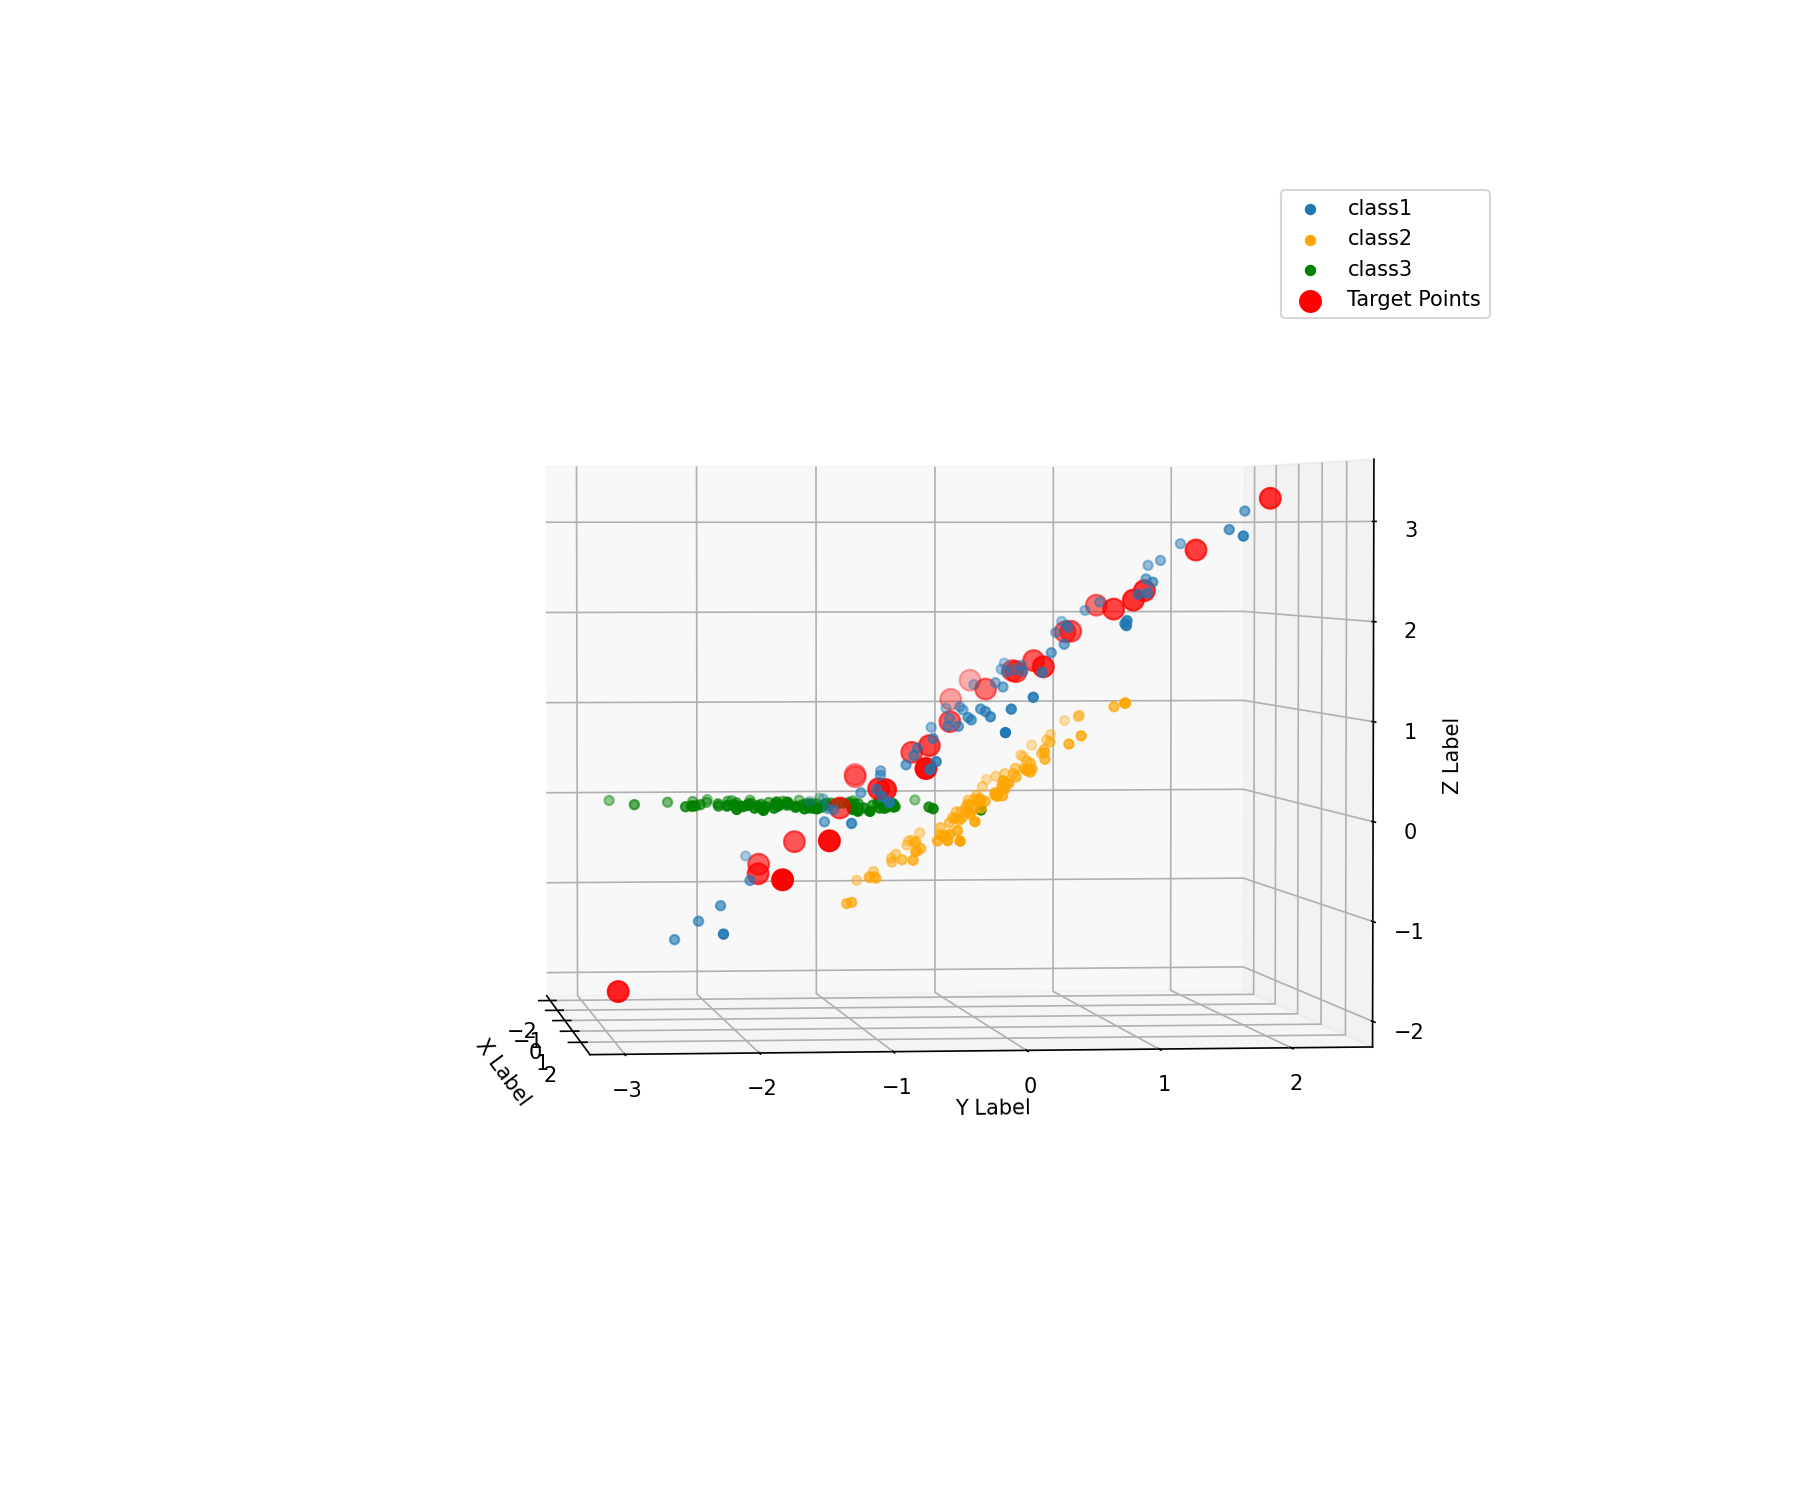

In [5]:
f = plt.figure(figsize=(12,10))
a = f.add_subplot(projection='3d')
a.scatter(z1[:,0],z1[:,1],z1[:,2],label = 'class1')
a.scatter(z2[:,0],z2[:,1],z2[:,2],color = 'orange',label = 'class2')
a.scatter(z3[:,0],z3[:,1],z3[:,2],color = 'g',label = 'class3')
a.scatter(tp[:,0],tp[:,1],tp[:,2],color = 'r',label = 'Target Points',s = 100)
a.set_xlabel('X Label')
a.set_ylabel('Y Label')
a.set_zlabel('Z Label')
a.legend()